<a href="https://colab.research.google.com/github/slneha/AIPI590_Fall2025/blob/main/Assignment2/AIPI_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading the Dataset & Imports

IMP! The two cells below are run as I have the kaggle json file containing the API details. For reproducing this code, the user needs to upload their own kaggle file

This notebook uses the [Telco Customer Churn dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) from Kaggle, originally provided by IBM. The dataset contains demographic, account, and service usage information for 7,043 customers, along with a binary churn indicator showing whether the customer left the company. The unique customer identifier (`customerID`) is excluded from modeling as it does not contribute predictive value.

The analysis focuses on interpretable models for understanding churn drivers. Three model families are considered:

- Linear regression, treating churn as a continuous variable, to provide a baseline for comparison.
- Logistic regression, the standard choice for binary classification, evaluated both with and without regularization (L1 and L2). This approach allows coefficients to be directly interpreted in terms of odds ratios for churn.
- Generalized Additive Models (GAMs), which extend logistic regression by incorporating smooth terms that capture nonlinear effects and interactions, offering improved predictive performance while retaining partial interpretability.


The notebook also includes exploratory data analysis (EDA) to evaluate assumptions for each model (the reason for using regularization is explained during the EDA), detailed interpretations of results, and a comparison of strengths and weaknesses to guide recommendations for the telecommunications company.


In [1]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download -d blastchar/telco-customer-churn
!unzip telco-customer-churn.zip

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 430MB/s]
Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,Lasso
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


In [4]:
data=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


#1. Exploratory Data Analysis to check Assumptions

## Data Overview and Quality Checks


In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
pd.DataFrame({'Feature': data.columns, 'Num Unique Values': data.nunique().values})

,Feature,Num Unique Values
0,customerID,7043
1,gender,2
2,SeniorCitizen,2
3,Partner,2
4,Dependents,2
5,tenure,73
6,PhoneService,2
7,MultipleLines,3
8,InternetService,3
9,OnlineSecurity,3


In [8]:
data.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


Based on data.info() and the other data distributions, there are many features that are objects, which may not reflect the actual null values. The data will be converted to numeric data later then evaluated.

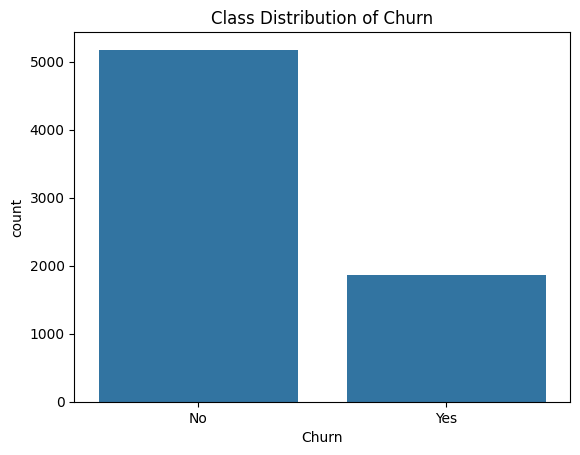

In [9]:

# Churn distribution
sns.countplot(x='Churn', data=data)
plt.title('Class Distribution of Churn')
plt.show()


The churn distribution plot showed that the dataset is imbalanced, with a majority of customers not churning and a smaller proportion leaving the service. Because of this imbalance, evaluation in Part 5 will not rely only on accuracy. Instead, the overall performance will be assessed using precision, recall, F1-score, and AUC.


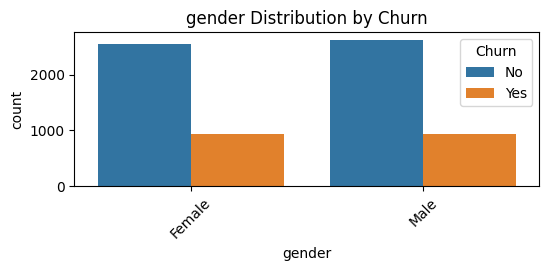

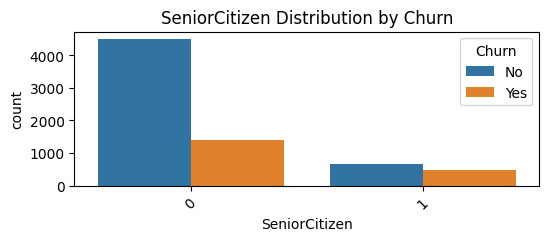

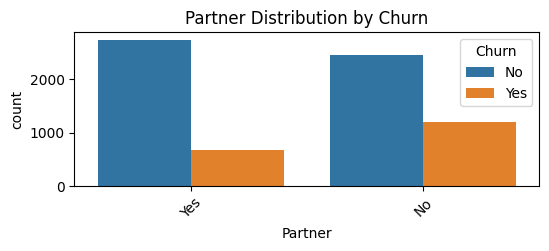

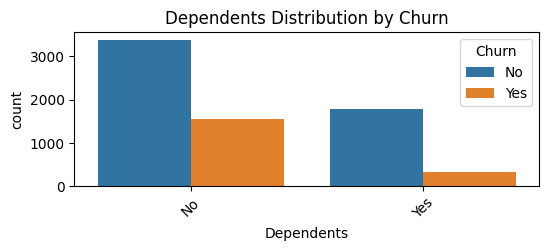

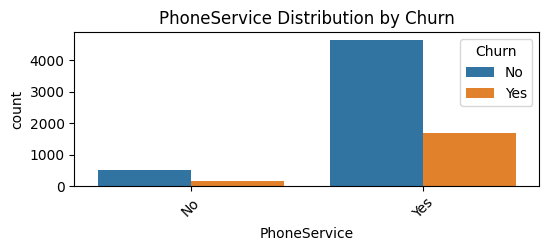

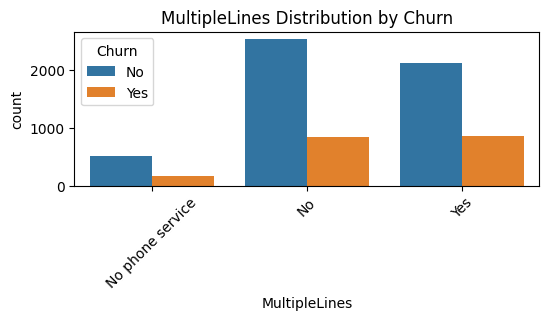

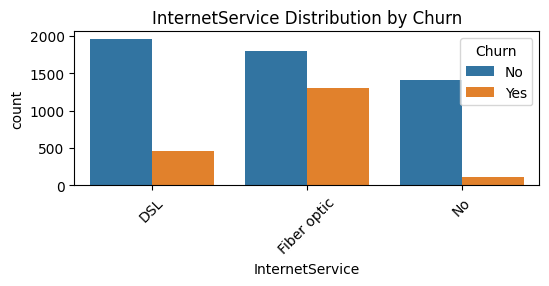

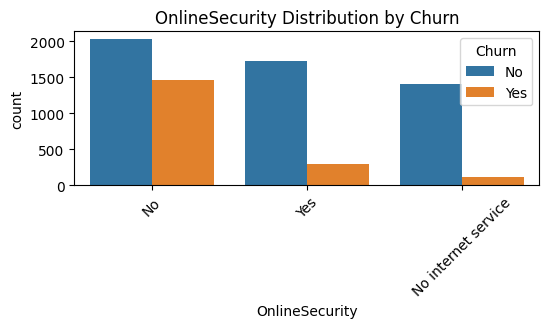

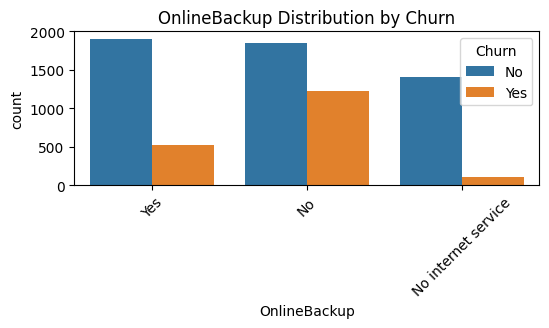

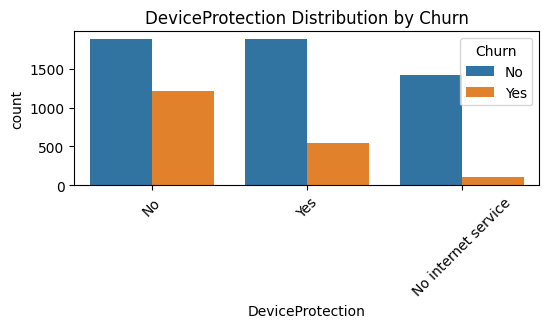

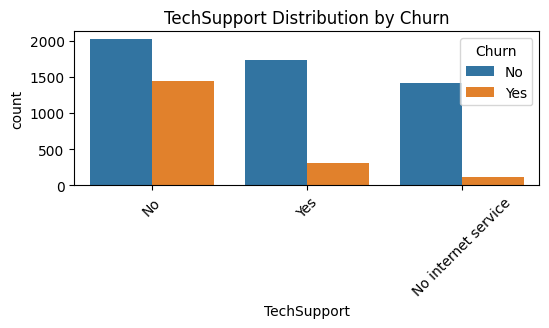

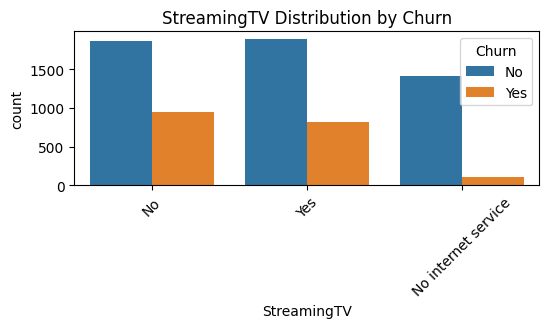

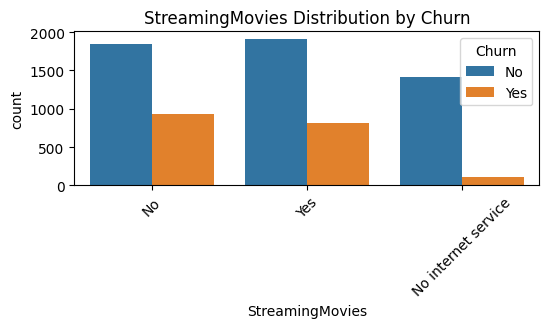

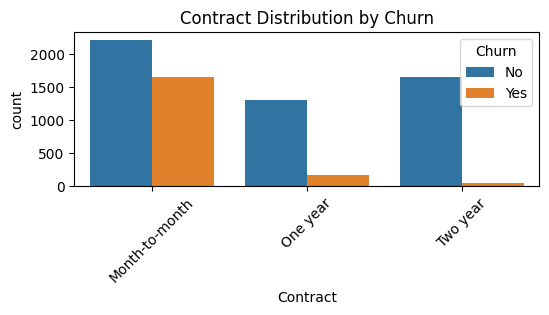

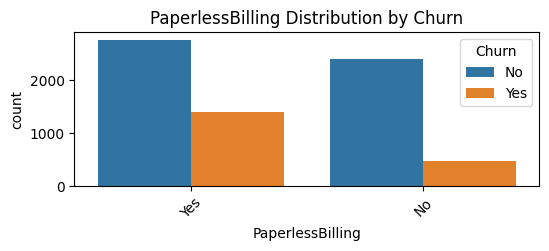

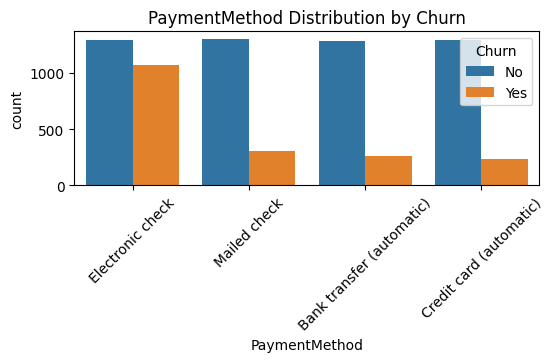

In [10]:
cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in cat_features:
    plt.figure(figsize=(6,2))
    sns.countplot(x=col, hue='Churn', data=data)
    plt.title(f'{col} Distribution by Churn')
    plt.xticks(rotation=45)
    plt.show()


The categorical feature plots revealed differences in churn across groups. Some data that was deduced includes that customers on month-to-month contracts, those without partners or dependents, and those using fiber optic internet are more likely to churn.

In [11]:

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
print(data['TotalCharges'].isnull().sum())  # Count of NaNs after coercion


11


In [12]:
data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'], errors='coerce')
print(data['MonthlyCharges'].isnull().sum())  # Count of NaNs after coercion


0


In [13]:
data['tenure'] = pd.to_numeric(data['tenure'], errors='coerce')
print(data['tenure'].isnull().sum())  # Count of NaNs after coercion


0


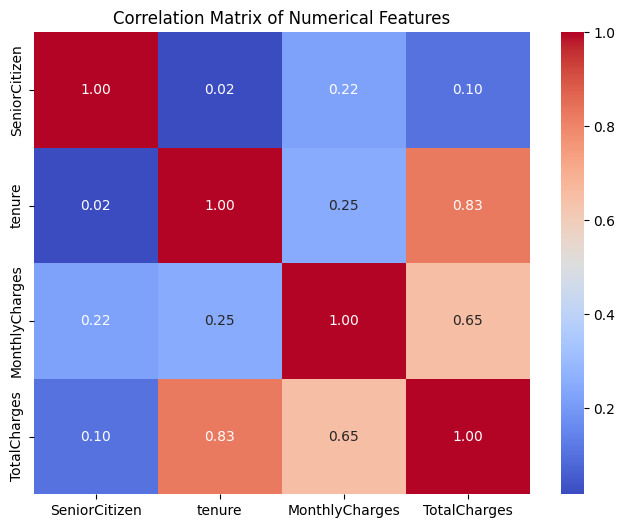

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(data.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


The correlation matrix revealed that tenure and total charges were highly correlated (0.83), showing the natural relationship where customers who remain longer accumulate higher overall charges. Monthly charges also showed a moderately strong correlation with total charges (0.65), since total charges are largely a function of monthly rate multiplied by tenure. These strong correlations indicate multicollinearity, which can lead to unstable coefficients in linear and logistic regression models, making interpretation difficult. By contrast, the SeniorCitizen variable displayed only weak correlations with other numerical variables (0.10 to 0.22), suggesting independence and no risk of multicollinearity.

For a further deepdive into multicollinearity, VIF will be used later.

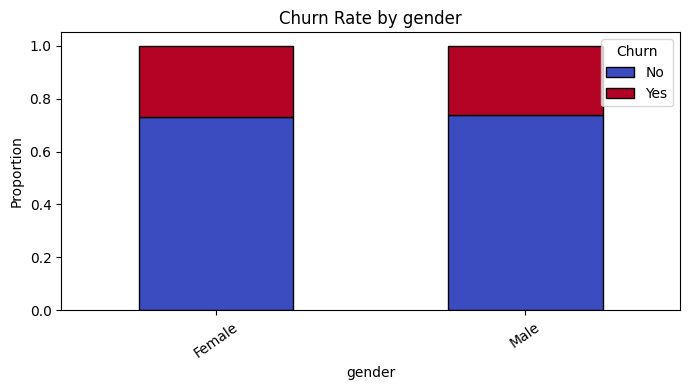

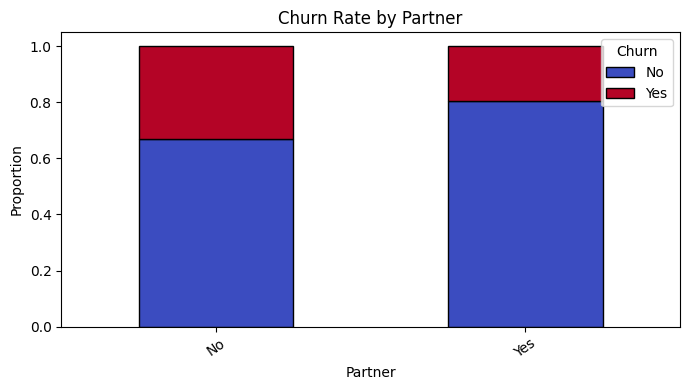

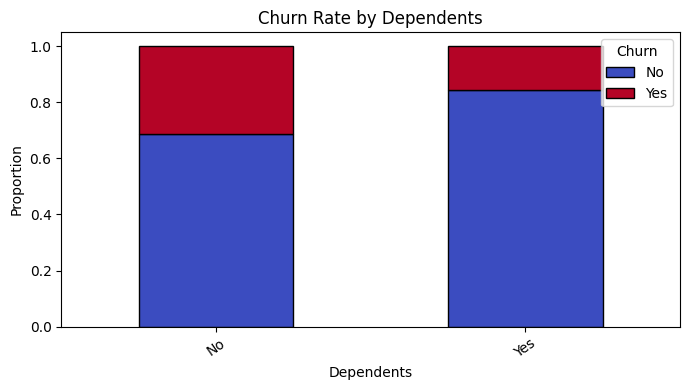

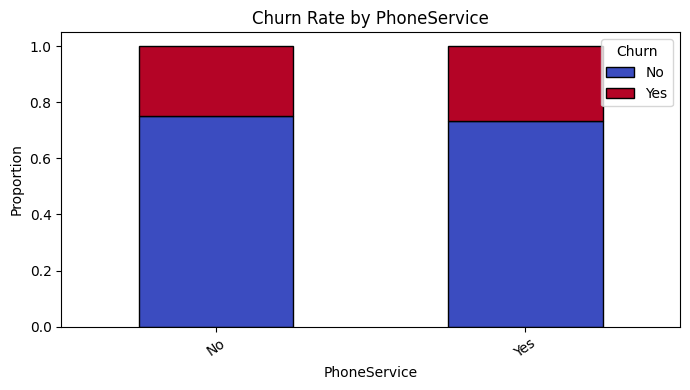

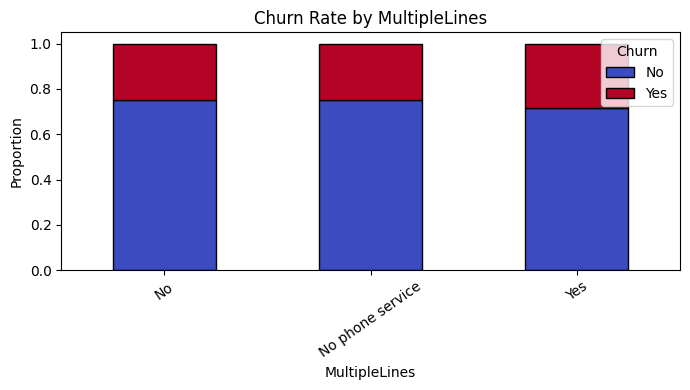

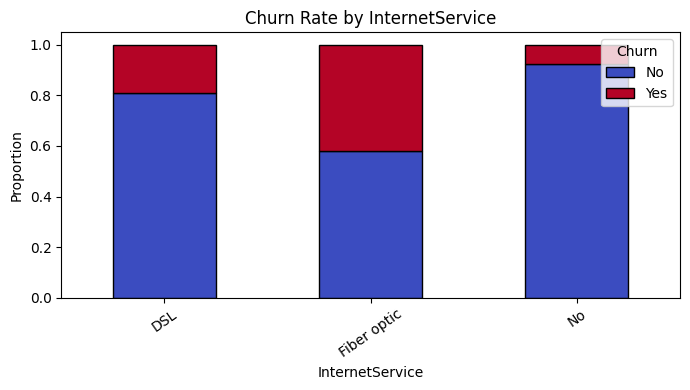

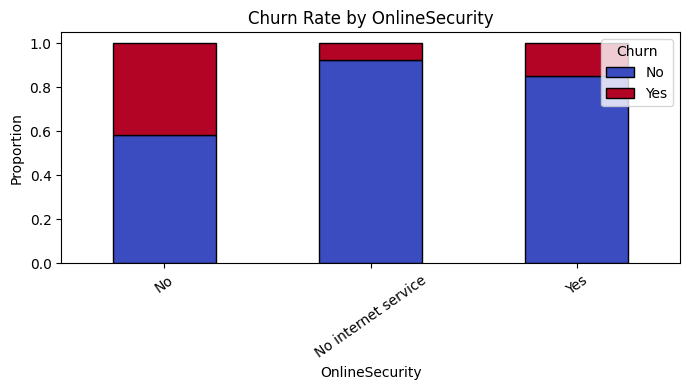

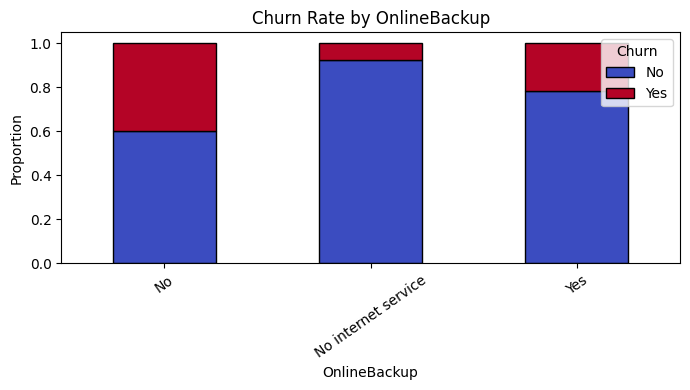

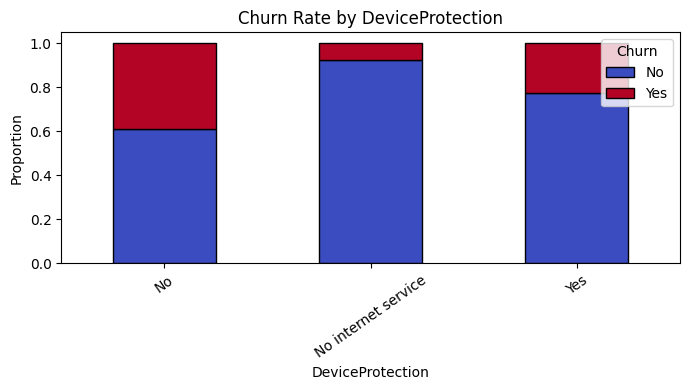

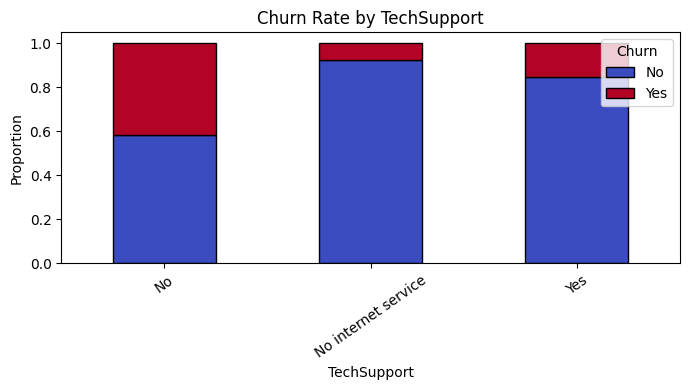

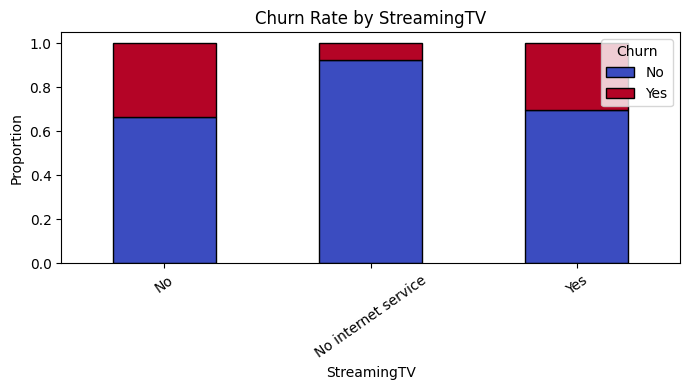

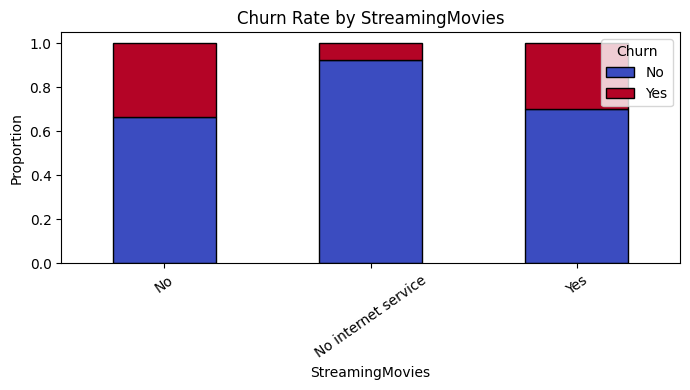

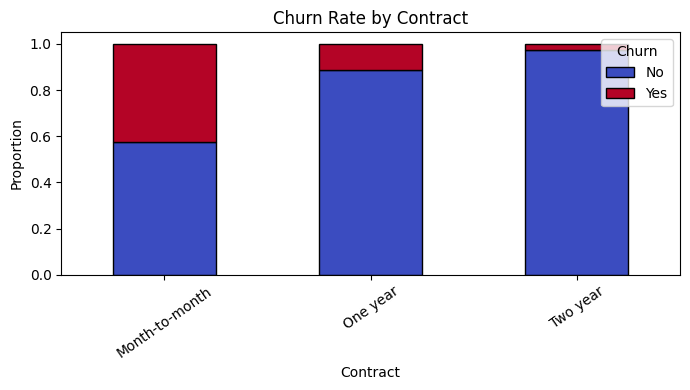

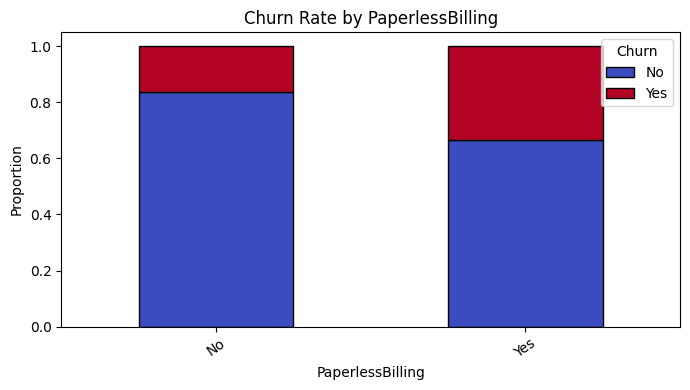

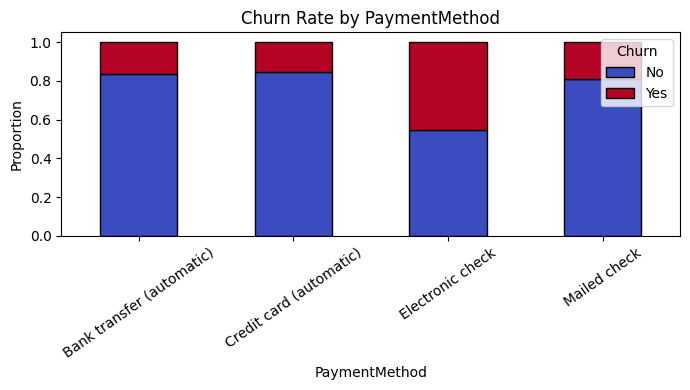

In [15]:
cat_cols = data.select_dtypes(include=['object', 'category']).columns
cat_cols = [col for col in cat_cols if col != 'Churn' and col != 'customerID']  # Exclude target

for col in cat_cols:
    churn_rate = data.groupby(col)['Churn'].value_counts(normalize=True).unstack()
    churn_rate.plot(kind='bar', stacked=True, figsize=(7,4), colormap='coolwarm', edgecolor='black')
    plt.title(f"Churn Rate by {col}")
    plt.ylabel("Proportion")
    plt.xlabel(col)
    plt.xticks(rotation=35)
    plt.legend(title='Churn', loc='upper right')
    plt.tight_layout()
    plt.show()


Customers with electronic check payment methods, shorter tenure, and no online security or tech support showed higher churn rates.


--- SeniorCitizen ---
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SeniorCitizen, dtype: float64
Skewness: 1.8332421986079817
Kurtosis: 1.360776958757027


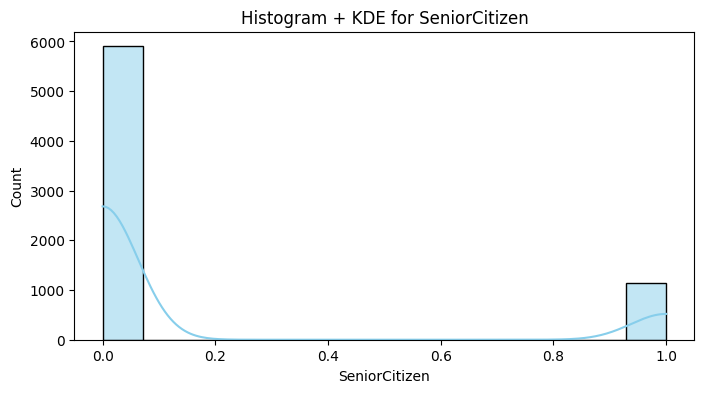

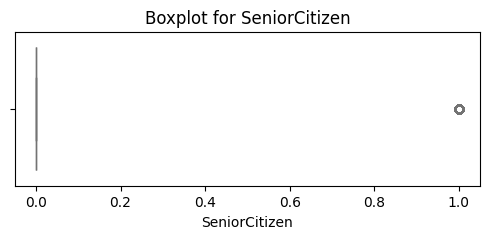


--- tenure ---
count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64
Skewness: 0.2394887299846216
Kurtosis: -1.3872386910324277


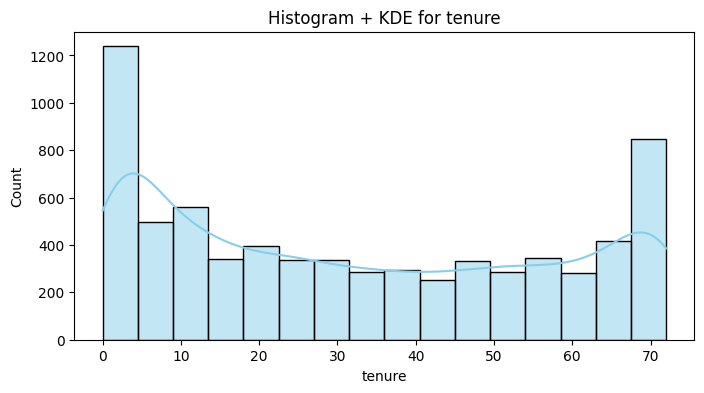

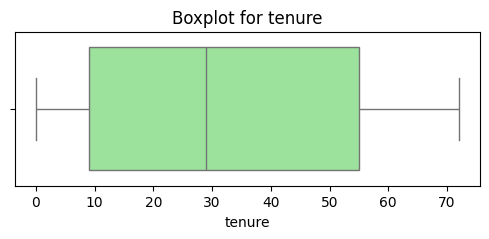


--- MonthlyCharges ---
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64
Skewness: -0.2204774644391769
Kurtosis: -1.2572191009381857


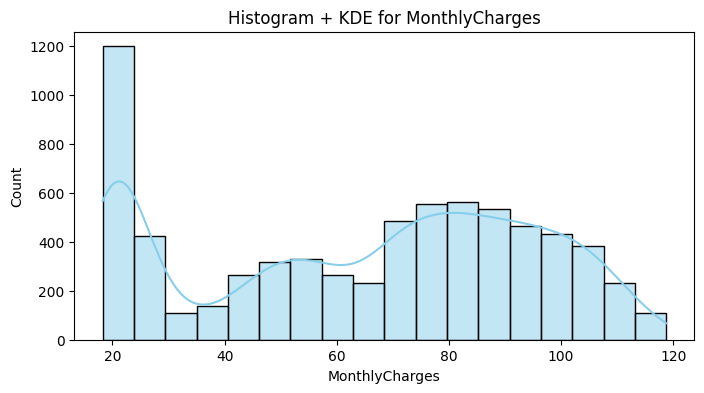

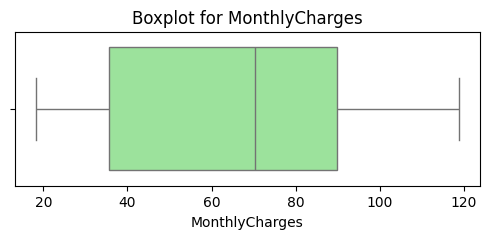


--- TotalCharges ---
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64
Skewness: nan
Kurtosis: nan


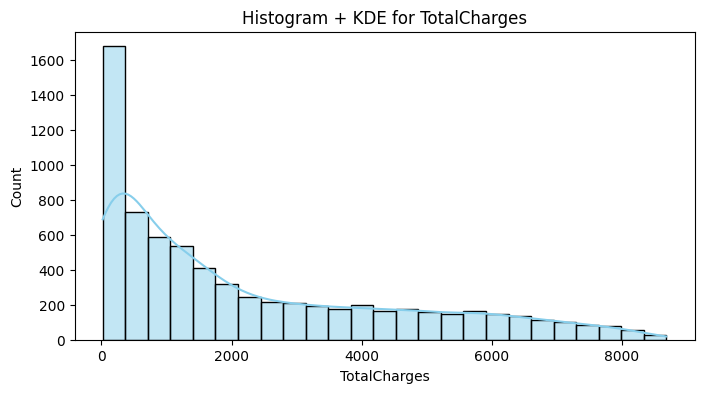

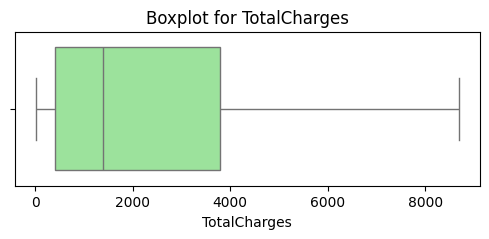

In [16]:
numerical_cols = data.select_dtypes(include=np.number).columns

for col in numerical_cols:
    print(f"\n--- {col} ---")
    print(data[col].describe())
    print(f"Skewness: {skew(data[col])}")
    print(f"Kurtosis: {kurtosis(data[col])}")

    # Histogram + KDE
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], kde=True, color='skyblue')
    plt.title(f'Histogram + KDE for {col}')
    plt.show()

    # Boxplot
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=data[col], color='lightgreen')
    plt.title(f'Boxplot for {col}')
    plt.show()

The numerical feature analysis showed distinct patterns with implications for modeling. SeniorCitizen, although reported with skewness and kurtosis values, is a binary variable with 84% coded as non-seniors, confirming its imbalance. Tenure had a mean of 32 months with a wide spread and a slightly right-skewed, flat distribution (kurtosis -1.39), suggesting both short-term and long-term customers are well represented; this likely produces nonlinear effects on churn. MonthlyCharges were centered around \$65, with a near-normal but slightly left-skewed distribution and light tails, making it a stable predictor for logistic regression while also leaving room for nonlinear contributions in GAM. TotalCharges, with a mean of \$2283 and a maximum exceeding \$8600, showed extreme variability and redundancy with tenure, reinforcing the need to address multicollinearity. Overall, the skewness and kurtosis results indicated that linear regression assumptions of normal residuals would not hold, but logistic regression and GAM could better capture the data's characteristics.


###Variance Inflation Factor

In [17]:
df = data.drop('customerID', axis=1)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

X = df.drop('Churn', axis=1)
y = df['Churn']



In [18]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
y = LabelEncoder().fit_transform(y)  # 'Yes' -> 1, 'No' -> 0

# One-hot encode features
X_encoded = pd.get_dummies(X, drop_first=True)
print(X_encoded.dtypes.value_counts())


bool       26
int64       2
float64     2
Name: count, dtype: int64


In [19]:
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes('bool').columns})
print(X_encoded.dtypes.value_counts())


int64      28
float64     2
Name: count, dtype: int64


In [20]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_const = sm.add_constant(X_encoded)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_encoded.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X_encoded.columns))]  # skip constant

# Sort and display top features by VIF
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data.head(15))


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                 Feature         VIF
8         MultipleLines_No phone service         inf
7                       PhoneService_Yes         inf
11                    InternetService_No         inf
12    OnlineSecurity_No internet service         inf
16  DeviceProtection_No internet service         inf
14      OnlineBackup_No internet service         inf
18       TechSupport_No internet service         inf
20       StreamingTV_No internet service         inf
22   StreamingMovies_No internet service         inf
2                         MonthlyCharges  866.089640
10           InternetService_Fiber optic  148.500814
23                   StreamingMovies_Yes   24.156394
21                       StreamingTV_Yes   24.080019
3                           TotalCharges   10.811490
1                                 tenure    7.584453


The above results indicate that there is high multicollinearity, which a problem because it makes it hard to tell which variable is truly affecting the outcome. The coefficients in the model become unstable and difficult to interpret. Statistical tests like p-values can become unreliable, leading to confusing results.

- In linear regression, multicollinearity causes coefficients to become unstable and may produce incorrect signs or sizes, making interpretation unreliable.

- In logistic regression, the odds ratios and coefficients can be misleading, making it difficult to understand the true effect of variables on the outcome.

- GAMs are more flexible and can handle some collinearity better, but strong multicollinearity can still cause unstable or redundant smooth terms.

In this analysis, some features are highly correlated, resulting in very high or infinite Variance Inflation Factor (VIF) values. These redundant variables should be removed or combined before modeling.

To handle multicollinearity, redundant features can be removed or combined. Regularization techniques like Ridge or Lasso regression can help. Tree-based models such as Random Forest or XGBoost can be used if interpretation is not the main goal. For interpretable linear or logistic models, it is best to keep VIF values below 5 or 10.

Overall, multicollinearity affects the stability and interpretability of linear and logistic regression models and should be addressed to build reliable and understandable models.


###Cook's Distance

Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 8


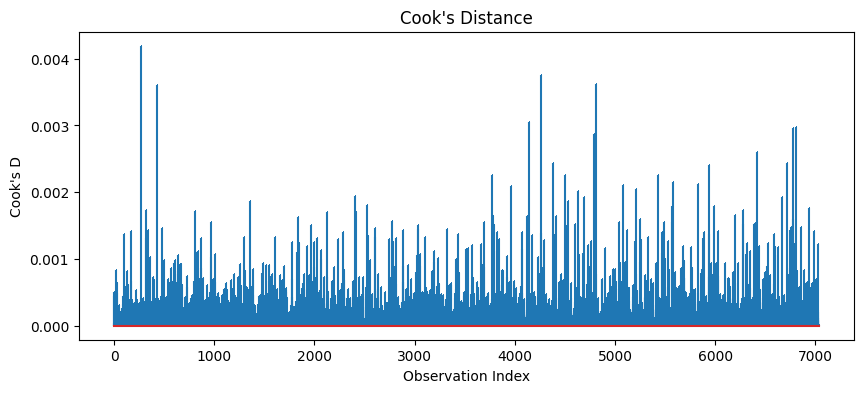

Number of influential points: 369
Indexes of influential points: [  18   31  104  110  131  141  168  173  268  317  320  335  336  345
  358  385  402  430  481  494  543  545  572  579  594  608  610  623
  628  637  640  653  657  673  677  727  729  797  808  809  826  828
  840  853  866  871  887  933  970  972  992 1011 1012 1118 1167 1198
 1240 1255 1259 1264 1302 1310 1320 1323 1360 1371 1390 1391 1472 1489
 1517 1542 1550 1570 1572 1587 1607 1653 1681 1696 1775 1781 1827 1832
 1835 1851 1887 1892 1923 1945 1960 1962 1976 1980 1998 2000 2014 2024
 2065 2069 2096 2122 2125 2180 2199 2239 2277 2280 2282 2292 2295 2388
 2407 2419 2446 2483 2514 2524 2531 2559 2605 2609 2633 2663 2747 2764
 2770 2775 2785 2799 2807 2813 2817 2885 2888 2889 2935 2960 3014 3023
 3024 3035 3037 3050 3053 3106 3173 3189 3192 3228 3235 3240 3321 3345
 3365 3368 3409 3433 3442 3511 3528 3571 3574 3580 3624 3666 3674 3681
 3688 3694 3773 3782 3784 3793 3797 3827 3837 3842 3868 3870 3883 3917
 3920 3938 3

In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

#Drop known redundant/collinear columns (if not we get an error)
redundant_cols = [
    'MultipleLines_No phone service',
    'OnlineSecurity_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'TechSupport_No internet service',
    'StreamingTV_No internet service',
    'StreamingMovies_No internet service'
]

X_cleaned=X_encoded.drop(columns=redundant_cols)

#Fit model
X_const=sm.add_constant(X_cleaned)
logit_model=sm.Logit(y, X_const).fit()

#Cook’s Distance
influence=logit_model.get_influence()
cooks_d=influence.cooks_distance[0]

plt.figure(figsize=(10, 4))
plt.stem(cooks_d, markerfmt=",")
plt.title("Cook's Distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's D")
plt.show()

#Identify influential points
n=X_cleaned.shape[0]
threshold=4/n
influential_points=np.where(cooks_d>threshold)[0]
print(f"Number of influential points: {len(influential_points)}")
print("Indexes of influential points:", influential_points)


Cook's Distance analysis indicates that 369 influential points exist in the dataset out of around 7,000 observations, which is about 5.2%. This proportion is large enough to potentially impact model stability.

- For linear regression, the assumptions are the most at risk. Since ordinary least squares is highly sensitive to influential points, violations of linearity and homoscedasticity may occur, and residuals may deviate from normality. The relatively high number of influential observations suggests that regression coefficients could shift significantly depending on their inclusion, making linear regression less reliable without robust alternatives.

- For logistic regression, the situation is slightly better. Logistic regression is less sensitive to outliers in the dependent variable but still vulnerable to high-leverage points among the predictors. Influential observations can distort the log-odds relationship, and they may also exaggerate predictor correlations. Although logistic regression is more robust than OLS, the 369 influential points suggest that coefficients and predicted probabilities could still be biased.

- For GAM models, the assumptions are most flexible. GAMs allow nonlinear relationships between predictors and the target, which reduces the impact of influential points compared to linear or logistic regression. However, if the influential points are clustered or extreme, they can still bias smooth functions, causing localized irregularities. With appropriate smoothing penalties and cross-validation, GAMs are expected to remain more stable in this scenario.

In conclusion, linear regression is the least robust to the influential observations, logistic regression is moderately affected, and GAMs are the most tolerant but still not entirely immune. The influential points should be further examined to determine whether they represent data quality issues or meaningful subgroups. Techniques such as robust regression, re-weighted GLMs, or sensitivity analyses may be beneficial.


###Linear Regression Assumptions

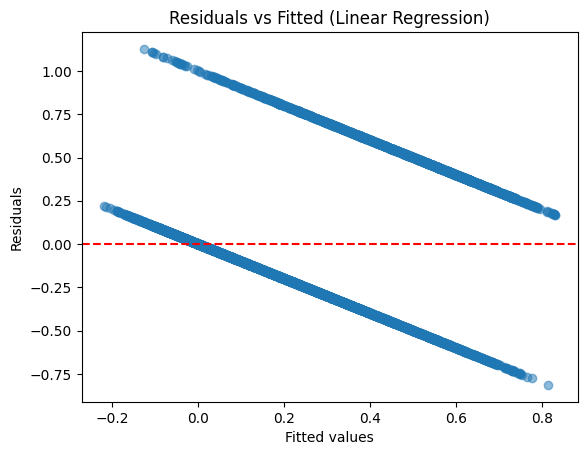

Breusch–Pagan p-value: 1.4942610719778871e-269
Shapiro–Wilk p-value: 2.0788787027639745e-39


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7032.
  res = hypotest_fun_out(*samples, **kwds)


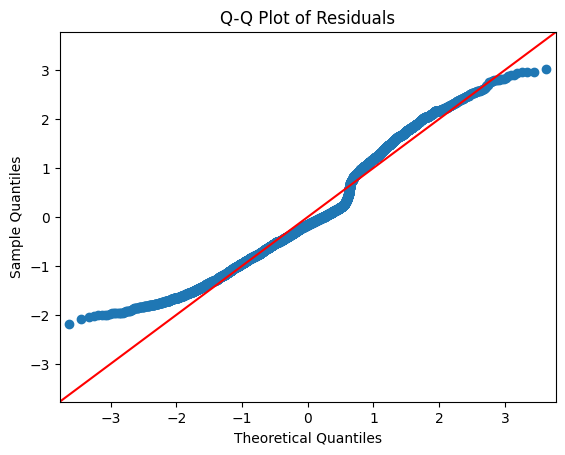

In [25]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Fit linear regression treating churn as continuous
y_lin=y
X_lin=sm.add_constant(X_encoded)
lin_model=sm.OLS(y_lin, X_lin).fit()

#Residuals vs fitted (linearity + homoscedasticity visual check)
residuals=lin_model.resid
fitted=lin_model.fittedvalues
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Linear Regression)")
plt.show()

#Breusch–Pagan test
bp_test=het_breuschpagan(residuals, X_lin)
bp_pvalue = bp_test[1]

#Normality check with Shapiro–Wilk (this time after removing high collinearity features)
shapiro_stat,shapiro_p=stats.shapiro(residuals)
print("Breusch–Pagan p-value:",bp_pvalue)
print("Shapiro–Wilk p-value:",shapiro_p)

# Q-Q plot for residuals
sm.qqplot(residuals,line='45',fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()


###Logistic Regression Assumptions

Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7008
Method:                           MLE   Df Model:                           23
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.2845
Time:                        03:14:11   Log-Likelihood:                -2913.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.8340      

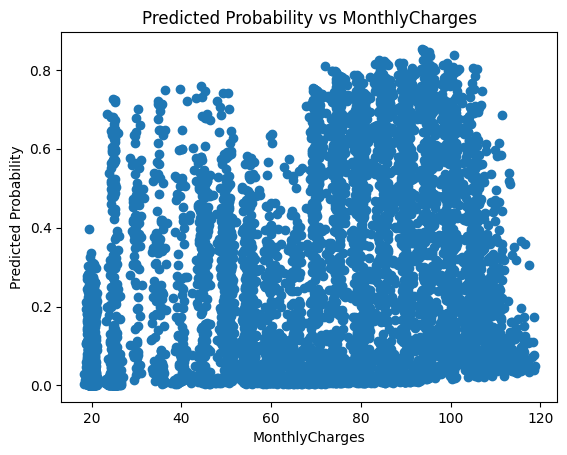

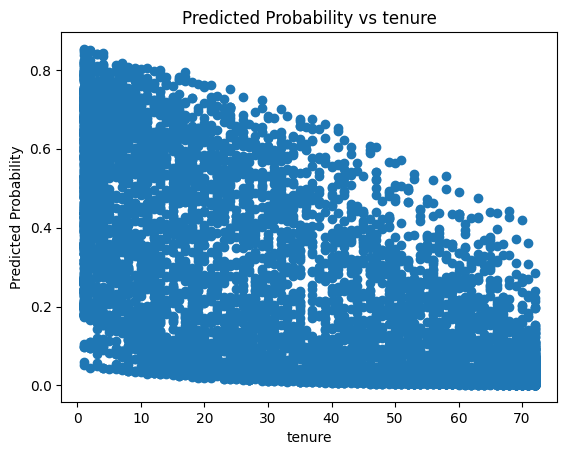

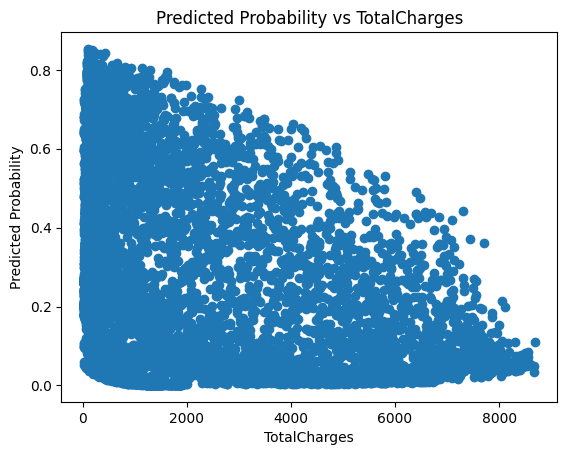

In [22]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tools import add_constant

# Fit logistic regression with statsmodels
logit_model = sm.Logit(y, sm.add_constant(X_encoded)).fit()
print(logit_model.summary())

# 1. Linearity in the logit: use Box-Tidwell test or plot
# Quick visualization for continuous variables:
for col in ['MonthlyCharges', 'tenure', 'TotalCharges']:  # continuous vars
    plt.scatter(X_encoded[col], logit_model.predict())
    plt.xlabel(col)
    plt.ylabel('Predicted Probability')
    plt.title(f'Predicted Probability vs {col}')
    plt.show()




In [31]:
from statsmodels.formula.api import logit
import numpy as np

# Box–Tidwell test for linearity in the logit (continuous vars only)
continuous_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_bt = data[continuous_vars].copy()

# Add interaction terms
for col in continuous_vars:
    X_bt[col+"_ln"] = X_bt[col] * np.log(X_bt[col].replace(0, np.nan))

# Add constant and drop missing
X_bt = sm.add_constant(X_bt.dropna())
y_bt = y[~X_bt.isna().any(axis=1)]

bt_model = sm.Logit(y_bt, X_bt).fit(disp=False)
print(bt_model.summary())



                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7025
Method:                           MLE   Df Model:                            6
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.2253
Time:                        04:59:47   Log-Likelihood:                -3154.4
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.7183      0.351     -2.047      0.041      -1.406      -0.031
tenure               -0.3518      0.044     -7.945      0.000      -0.439      -0.265
MonthlyCharges       -0.

The Box-Tidwell test was used to formally check the assumption of linearity in the logit for continuous variables. The results showed that tenure and total charges had statistically significant log-interaction terms (p < 0.001), indicating violations of the linearity assumption. In contrast, monthly charges was not significant (p = 0.365), suggesting that the logit is approximately linear in this predictor. These findings align with the earlier visual checks, where churn probability displayed nonlinear patterns with tenure and total charges. This further supports the use of flexible modeling approaches such as GAM to capture the nonlinear effects.


###GAM Assumptions

In [28]:
!pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 3.4 MB/s eta 0:00:00


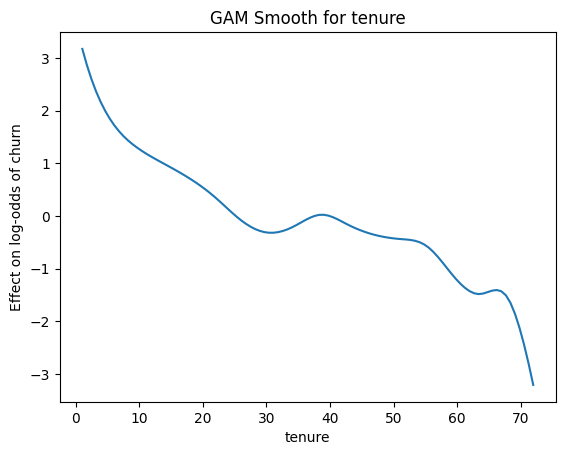

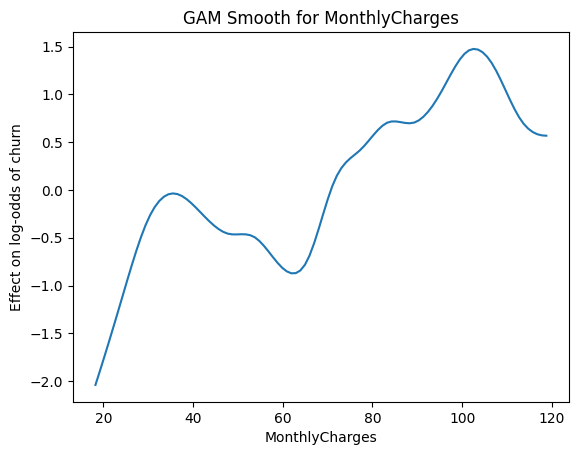

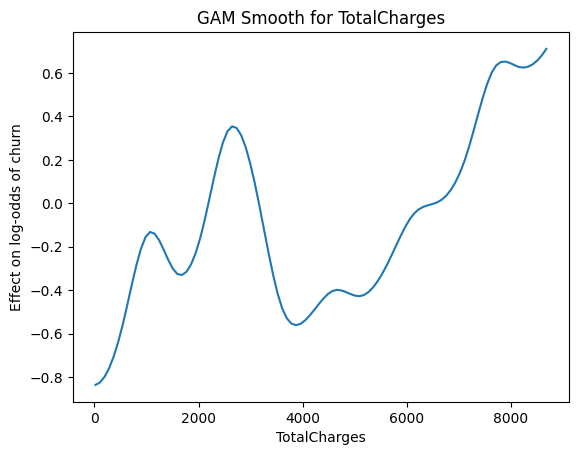

In [29]:
from pygam import LogisticGAM, s

continuous_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
gam = LogisticGAM(s(0) + s(1) + s(2)).fit(X_encoded[continuous_vars], y)

# Plot smooth functions
for i, term in enumerate(continuous_vars):
    plt.figure()
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"GAM Smooth for {term}")
    plt.xlabel(term)
    plt.ylabel("Effect on log-odds of churn")
    plt.show()


The smooth functions from the GAM highlighted the nonlinear relationships between key continuous variables and churn.
- For tenure, the effect on the log-odds of churn decreased steeply in the first year, leveled off during mid-tenure, and declined again for long-term customers. This pattern reinforces that the risk of churn is highest early in the customer lifecycle, tapering off as customers remain longer.
- Monthly charges showed a fluctuating pattern, with churn risk increasing at higher charge levels but not in a strictly linear fashion.
- Total charges also displayed oscillations, consistent with its strong dependence on tenure and monthly charges.

These curves show that linear and logistic models are insufficient to capture the nuanced effects of tenure and billing on churn, while GAMs provide the flexibility to model such nonlinearities directly.


Overall Conclusion

The exploratory analysis and assumption checks revealed clear implications for model choice. Linear regression was shown to be the least appropriate, as residual diagnostics confirmed strong violations of homoscedasticity (Breusch–Pagan p < 1e-200) and normality (Shapiro–Wilk p ≈ 2.1 × 10⁻³⁹). Combined with the presence of 369 influential points (around 5.2% of the dataset), linear regression would produce unstable and unreliable estimates. Logistic regression offered improvements, but the Box-Tidwell test and probability plots indicated violations of the linearity-in-the-logit assumption for tenure and total charges, consistent with earlier skewness and multicollinearity findings. These limitations suggest that logistic regression can be useful for interpretability and probability estimation but will not fully capture nonlinear patterns in churn.

By contrast, GAM smooth functions for tenure, monthly charges, and total charges highlighted strong nonlinear relationships with churn risk. GAMs provide the flexibility to model these patterns directly, mitigating the issues that undermine linear and logistic approaches. However, the analysis also revealed that high multicollinearity between tenure and total charges, as well as the presence of influential points, could still bias smooth terms if left unaddressed.

Overall, linear regression is not suitable for churn modeling in this dataset, logistic regression provides interpretable baseline insights with important limitations, and GAMs present the most appropriate modeling framework by capturing nonlinear effects.

#2. Linear Regression

###Without Regularization

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Predictions from linear regression
y_pred_lin = lin_model.predict(X_lin)

# Convert to binary classification using 0.5 cutoff
y_class_lin = np.where(y_pred_lin >= 0.5, 1, 0)

# Classification metrics
precision = precision_score(y_lin, y_class_lin)
recall = recall_score(y_lin, y_class_lin)
f1 = f1_score(y_lin, y_class_lin)
auc = roc_auc_score(y_lin, y_pred_lin)

print("Linear Regression Classification Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")


Linear Regression Classification Metrics:
Precision: 0.6646
Recall:    0.5174
F1 Score:  0.5818
AUC:       0.8396


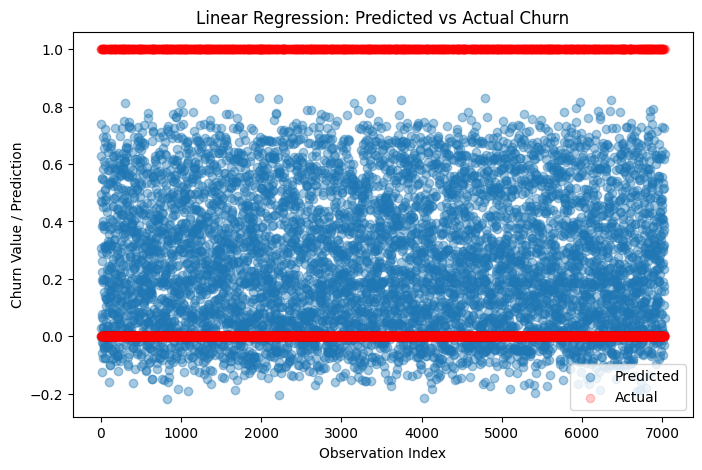

In [34]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(y_lin)), y_pred_lin, alpha=0.4, label="Predicted")
plt.scatter(range(len(y_lin)), y_lin, alpha=0.2, label="Actual", color="red")
plt.xlabel("Observation Index")
plt.ylabel("Churn Value / Prediction")
plt.title("Linear Regression: Predicted vs Actual Churn")
plt.legend()
plt.show()


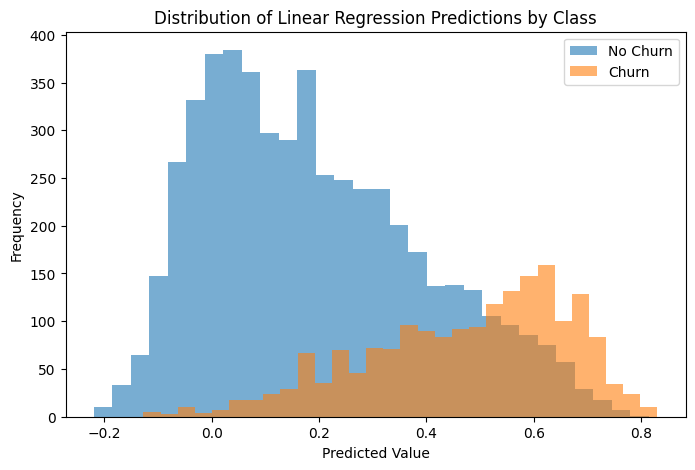

In [35]:
plt.figure(figsize=(8,5))
plt.hist(y_pred_lin[y_lin==0], bins=30, alpha=0.6, label="No Churn")
plt.hist(y_pred_lin[y_lin==1], bins=30, alpha=0.6, label="Churn")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.title("Distribution of Linear Regression Predictions by Class")
plt.legend()
plt.show()


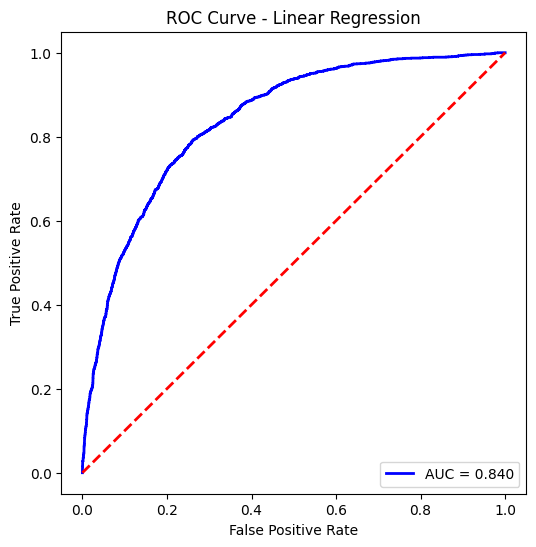

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_lin, y_pred_lin)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="red", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Linear Regression")
plt.legend(loc="lower right")
plt.show()


Although the linear regression model converged successfully, several limitations are quite evident. The predicted vs actual scatterplot showed that the model generated continuous values extending outside the valid probability range of [0, 1], and the distribution plots showed heavy overlap between churners and non-churners, which confirmed weak class separation.

Despite these limitations, classification metrics were computed for comparison. Using a 0.5 cutoff, the model achieved a precision of 0.665, recall of 0.517, and F1-score of 0.582. The ROC curve produced an AUC of 0.840, indicating moderate discriminatory ability despite the structural flaws of the model. These results overall emphasize that linear regression provides limited insight for churn classification and can't really serve as a reliable predictive framework.

###With Regularization

####Ridge Regression

In [43]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_encoded, y)
ridge_preds = ridge.predict(X_encoded)
ridge_class = (ridge_preds >= 0.5).astype(int)

print("Ridge Precision:", precision_score(y, ridge_class))
print("Ridge Recall:", recall_score(y, ridge_class))
print("Ridge F1:", f1_score(y, ridge_class))
print("Ridge AUC:", roc_auc_score(y, ridge_preds))




Ridge Precision: 0.6636925188743995
Ridge Recall: 0.5173889780631353
Ridge F1: 0.5814792543595911
Ridge AUC: 0.8395688464044331


####Lasso Regression

In [62]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_encoded, y)
lasso_preds = lasso.predict(X_encoded)
lasso_class = (lasso_preds >= 0.5).astype(int)
print("Lasso Precision:", precision_score(y, lasso_class))
print("Lasso Recall:", recall_score(y, lasso_class))
print("Lasso F1:", f1_score(y, lasso_class))
print("Lasso AUC:", roc_auc_score(y, lasso_preds))

Lasso Precision: 0.6692094313453537
Lasso Recall: 0.516318887105404
Lasso F1: 0.5829054666263969
Lasso AUC: 0.838930118376351


The base model produced a precision of **0.6646**, recall of **0.5174**, and F1 score of **0.5818**, with an AUC of **0.8396**. These results indicate that while the model is relatively precise in predicting churners, it struggles to capture all churn cases (lower recall), which reduces the F1 balance.

When regularization was applied, both Ridge and Lasso regression showed nearly identical performance to the base model. Ridge regression achieved a precision of **0.6637**, recall of **0.5174**, F1 score of **0.5815**, and AUC of **0.8396**. Lasso regression produced a precision of **0.6692**, recall of **0.5163**, F1 score of **0.5829**, and AUC of **0.8389**.  

Overall, the regularized models did not significantly improve predictive ability compared to the unregularized linear regression, suggesting that linear regression, even with L1/L2 penalties, may not be sufficiently flexible to capture the nonlinear relationships inherent in customer churn data, and more sophisticated models such as logistic regression or GAMs provide stronger predictive performance.


#3. Logistic Regression

###Without Regularization

In [37]:
import statsmodels.api as sm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Define X and y
X_log = sm.add_constant(X_encoded)  # add intercept
y_log = y

# Fit logistic regression
logit_model = sm.Logit(y_log, X_log).fit()
print(logit_model.summary())

# Predictions (probabilities)
y_pred_prob = logit_model.predict(X_log)

# Convert to binary classification using 0.5 cutoff
y_class_log = (y_pred_prob >= 0.5).astype(int)

# Classification metrics
precision = precision_score(y_log, y_class_log)
recall = recall_score(y_log, y_class_log)
f1 = f1_score(y_log, y_class_log)
auc_val = roc_auc_score(y_log, y_pred_prob)

print("Logistic Regression Classification Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc_val:.4f}")


Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7008
Method:                           MLE   Df Model:                           23
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.2845
Time:                        05:30:31   Log-Likelihood:                -2913.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.8340      

In [84]:
params=logit_model.params
conf=logit_model.conf_int()
conf['coef']=params

# Exponentiate coefficients and confidence intervals
odds_ratios=np.exp(conf)
odds_ratios.columns=['CI Lower (2.5%)', 'CI Upper (97.5%)', 'Odds Ratio']

# Make it a clean dataframe
odds_table=odds_ratios.reset_index().rename(columns={'index': 'Feature'})

# Display top 10 features by absolute effect size
odds_table['abs_effect']=np.abs(np.log(odds_table['Odds Ratio']))
odds_table.sort_values(by='abs_effect',ascending=False).drop(columns='abs_effect').head(10)

/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


,Feature,CI Lower (2.5%),CI Upper (97.5%),Odds Ratio
11,InternetService_Fiber optic,NaN,NaN,5.740090
26,Contract_Two year,0.188679,0.351164,0.257405
0,const,NaN,NaN,2.302543
25,Contract_One year,0.418853,0.636764,0.516440
24,StreamingMovies_Yes,1.447868,2.289879,1.820836
22,StreamingTV_Yes,1.358666,2.397703,1.804904
8,PhoneService_Yes,NaN,NaN,1.653247
10,MultipleLines_Yes,1.305254,1.878349,1.565798
27,PaperlessBilling_Yes,1.217933,1.628325,1.408258
9,MultipleLines_No phone service,0.000000,inf,1.392740


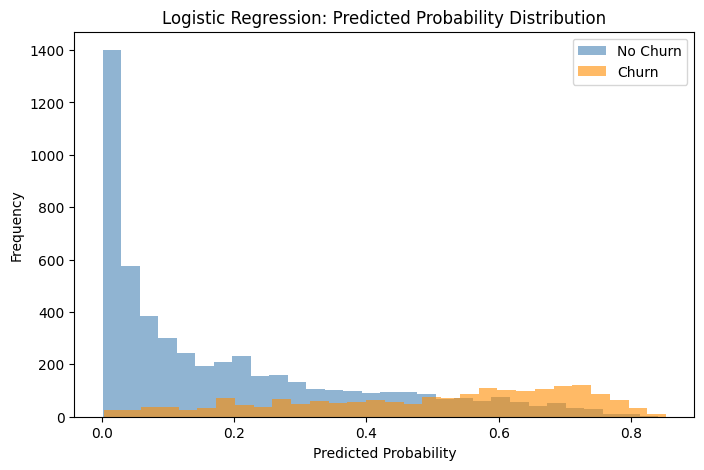

In [38]:
plt.figure(figsize=(8,5))
plt.hist(y_pred_prob[y_log==0], bins=30, alpha=0.6, label="No Churn", color="steelblue")
plt.hist(y_pred_prob[y_log==1], bins=30, alpha=0.6, label="Churn", color="darkorange")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Logistic Regression: Predicted Probability Distribution")
plt.legend()
plt.show()


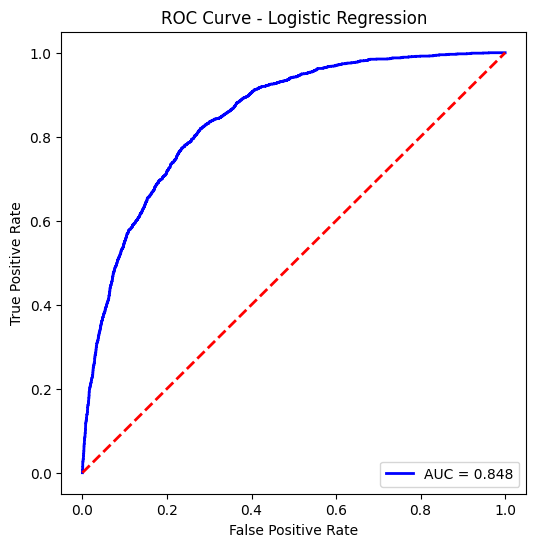

In [39]:
fpr, tpr, _ = roc_curve(y_log, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="red", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()


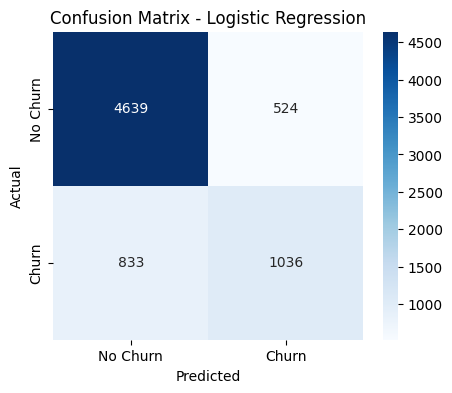

In [40]:
import seaborn as sns
cm = confusion_matrix(y_log, y_class_log)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


###With Regularization

####Ridge penalty

In [49]:
log_reg_l2 = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=1000)
log_reg_l2.fit(X_encoded, y)
y_pred_prob_l2 = log_reg_l2.predict_proba(X_encoded)[:,1]
y_class_l2 = log_reg_l2.predict(X_encoded)

print("LogReg L2 Precision:", precision_score(y, y_class_l2))
print("LogReg L2 Recall:", recall_score(y, y_class_l2))
print("LogReg L2 F1:", f1_score(y, y_class_l2))
print("LogReg L2 AUC:", roc_auc_score(y, y_pred_prob_l2))


LogReg L2 Precision: 0.6628131021194605
LogReg L2 Recall: 0.5521669341894061
LogReg L2 F1: 0.6024518388791593
LogReg L2 AUC: 0.8480229380411533


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


####Lasso penalty

In [50]:
log_reg_l1 = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
log_reg_l1.fit(X_encoded, y)
y_pred_prob_l1 = log_reg_l1.predict_proba(X_encoded)[:,1]
y_class_l1 = log_reg_l1.predict(X_encoded)

print("LogReg L1 Precision:", precision_score(y, y_class_l1))
print("LogReg L1 Recall:", recall_score(y, y_class_l1))
print("LogReg L1 F1:", f1_score(y, y_class_l1))
print("LogReg L1 AUC:", roc_auc_score(y, y_pred_prob_l1))

LogReg L1 Precision: 0.6624040920716112
LogReg L1 Recall: 0.5543071161048689
LogReg L1 F1: 0.6035537430818526
LogReg L1 AUC: 0.8480450632028302


The logistic regression model was fitted using maximum likelihood estimation (MLE). The model converged successfully with a pseudo R² of 0.285, indicating that the model provides a reasonable level of explanatory power for customer churn.

The coefficients reveal important relationships. Tenure has a negative coefficient (-0.0606, p < 0.001), suggesting that customers with longer tenure are less likely to churn. MonthlyCharges shows instability due to multicollinearity, while TotalCharges has a small but positive effect (+0.0003, p < 0.001), indicating that higher accumulated charges slightly increase the likelihood of churn. Customers with fiber optic internet are much more likely to churn (+1.7475), while those with one-year or two-year contracts are less likely to churn, consistent with the idea that longer commitments discourage customer attrition. Customers paying via electronic check have an increased likelihood of churn (+0.3045).

Additionally, the odds ratio shows that two-year and one-year contracts strongly reduce churn, while month-to-month customers remain at higher risk. Fiber optic internet, paperless billing, and electronic payment options increase churn risk, aligning with business intuition about dissatisfaction drivers. Streaming services and multiple lines are also associated with higher churn odds. These findings make logistic regression valuable not only for prediction but also for explaining which customer groups are most vulnerable and why.

The classification metrics for the base logistic regression model show Precision of 0.6641, Recall of 0.5543, F1 Score of 0.6043, and AUC of 0.8482. When regularization is applied, results remain essentially unchanged. Logistic regression with Ridge regularization yields Precision 0.6628, Recall 0.5522, F1 Score 0.6025, and AUC 0.8480. Logistic regression with Lasso regularization produces Precision 0.6624, Recall 0.5543, F1 Score 0.6036, and AUC 0.8480. This stability indicates that the model is not highly sensitive to regularization and suggests no significant performance gain.

The plots further confirm model performance. The predicted probability distribution shows that non-churn customers are concentrated in the 0-0.2 probability range, while churn customers are spread across higher probabilities, generally between 0.5 and 0.7. This separation is clear, though some overlap remains. The ROC curve demonstrates strong discrimination ability, with an AUC of 0.848, which is an improvement compared to linear regression. The confusion matrix shows that the model correctly identifies a majority of churners, but also highlights that a substantial number of churners are still missed.

In conclusion, logistic regression, whether with or without regularization, outperforms linear regression in both F1 Score and AUC. The predicted probability distributions, ROC curve, and confusion matrix confirm that the model provides solid predictive performance and meaningful insights into churn behavior.


#4. Generalized Additive Model (GAM)

In [61]:
import numpy as np
from pygam import LogisticGAM, s, te, l
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve

# --- Continuous feature indices ---
ten_idx = X_encoded.columns.get_loc("tenure")
mc_idx  = X_encoded.columns.get_loc("MonthlyCharges")

# --- Build GAM terms: smooths + interaction ---
terms = (
    s(ten_idx, n_splines=50) +
    s(mc_idx, n_splines=50) +
    te(ten_idx, mc_idx, n_splines=[20,20])
)

cat_keep = [c for c in X_encoded.columns if any(x in c for x in [
    "Contract", "InternetService", "PaymentMethod",
    "PaperlessBilling", "Streaming", "SeniorCitizen"
])]
for c in cat_keep:
    terms += l(X_encoded.columns.get_loc(c))

# --- Convert to arrays ---
X_np = X_encoded.to_numpy()
y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.array(y)

# --- Compute churn weight (to balance minority class) ---
churn_weight = (len(y_np) - y_np.sum()) / y_np.sum()
weights = np.where(y_np==1, churn_weight, 1)

# --- Fit GAM with smoothing grid search and weights ---
lam_grid = np.logspace(-5, 5, 15)
gam = LogisticGAM(terms).gridsearch(X_np, y_np, lam=lam_grid, weights=weights)

# --- Predictions ---
y_pred_prob_gam = gam.predict_proba(X_np)
prec, rec, thr = precision_recall_curve(y_np, y_pred_prob_gam)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_i = np.argmax(f1s)
best_thr = thr[max(0, best_i-1)] if len(thr) else 0.5

y_class_gam = (y_pred_prob_gam >= best_thr).astype(int)

# --- Metrics ---
precision = precision_score(y_np, y_class_gam)
recall    = recall_score(y_np, y_class_gam)
f1        = f1_score(y_np, y_class_gam)
auc       = roc_auc_score(y_np, y_pred_prob_gam)

print("Improved GAM (tuned, weighted)")
print(f"Threshold: {best_thr:.3f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")


  0% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.12/dist-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/usr/local

did not converge


/usr/local/lib/python3.12/dist-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
 13% (2 of 15) |###                      | Elapsed Time: 0:00:37 ETA:   0:04:03

did not converge


/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.12/dist-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/utils.py:786: RuntimeWarning: divide by zer

did not converge


/usr/local/lib/python3.12/dist-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.12/dist-packages/pygam/utils.py:786: RuntimeWarning: divide by zer

did not converge


/usr/local/lib/python3.12/dist-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.12/dist-packages/pygam/utils.py:786: RuntimeWarning: divide by zer

did not converge


/usr/local/lib/python3.12/dist-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.12/dist-packages/pygam/utils.py:786: RuntimeWarning: divide by zer

did not converge


/usr/local/lib/python3.12/dist-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
100% (15 of 15) |########################| Elapsed Time: 0:03:39 Time:  0:03:39


Improved GAM (tuned, weighted)
Threshold: 0.573
Precision: 0.5804
Recall:    0.7624
F1 Score:  0.6591
AUC:       0.8602


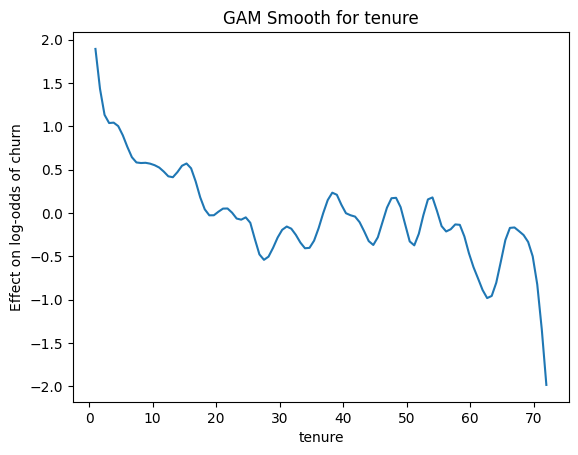

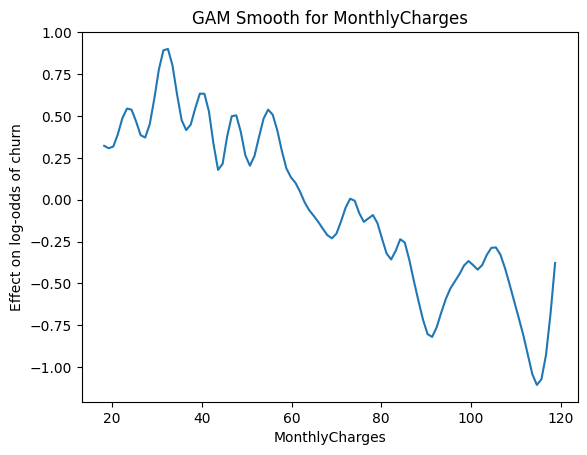

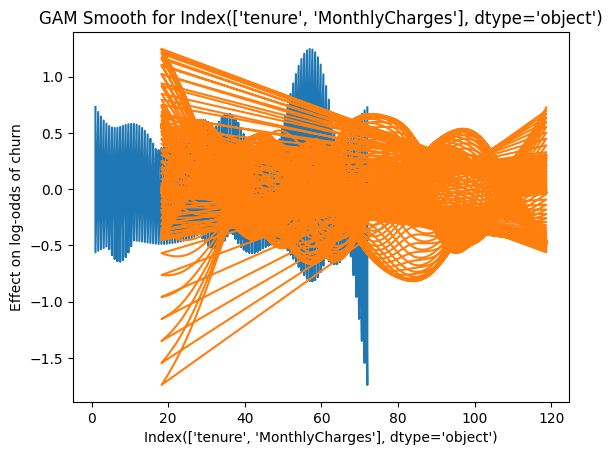

In [71]:
from pygam.terms import SplineTerm

# Loop over all terms and plot smooths only
for i, term in enumerate(gam.terms):
    if isinstance(term, SplineTerm):  # only smooth terms
        XX = gam.generate_X_grid(term=i)
        plt.figure()
        plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
        plt.title(f"GAM Smooth for {X_encoded.columns[term.feature]}")
        plt.xlabel(X_encoded.columns[term.feature])
        plt.ylabel("Effect on log-odds of churn")
        plt.show()


In [76]:
from mpl_toolkits.mplot3d import Axes3D

# Find the index of the tensor interaction term in the model
for i,term in enumerate(gam.terms):
    print(i,term)


0 spline_term
1 spline_term
2 tensor_term
3 linear_term
4 linear_term
5 linear_term
6 linear_term
7 linear_term
8 linear_term
9 linear_term
10 linear_term
11 linear_term
12 linear_term
13 linear_term
14 linear_term
15 linear_term
16 intercept_term


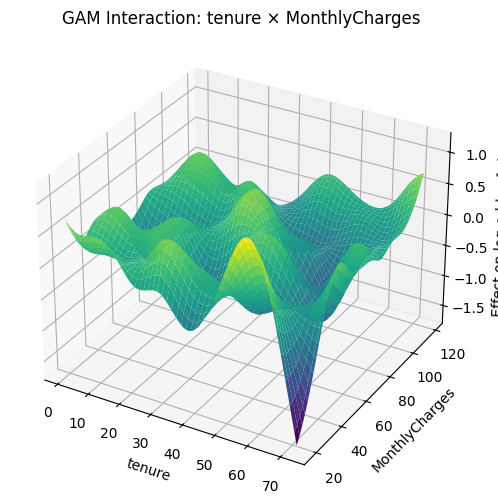

In [77]:
interaction_idx=2

# Generate 2D grid and partial dependence
XX=gam.generate_X_grid(term=interaction_idx,meshgrid=True)
Z=gam.partial_dependence(term=interaction_idx,X=XX,meshgrid=True)

# Plot as 3D surface
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(XX[0],XX[1],Z,cmap="viridis",edgecolor='none')

ax.set_xlabel("tenure")
ax.set_ylabel("MonthlyCharges")
ax.set_zlabel("Effect on log-odds of churn")
ax.set_title("GAM Interaction: tenure × MonthlyCharges")
plt.show()

In the GAM, the smooth for tenure indicated that churn risk is highest for customers with very short tenures, and the effect steadily decreases as tenure increases, showing that long-term customers are less likely to churn. The smooth for MonthlyCharges revealed a non-linear pattern, with churn risk initially rising for mid-level charges before declining at higher charge levels, suggesting that customers with moderate bills are the most vulnerable. The smooth for TotalCharges followed a similar trend, with fluctuations that highlight complex spending-related dynamics.

The interaction surface between tenure and MonthlyCharges demonstrated that the combined effect of these two features is not purely additive. For customers with short tenures, higher MonthlyCharges significantly increased churn risk, while for long-tenure customers, the influence of charges diminished or even reversed in some regions. This highlights that churn risk depends not just on individual features, but also on how they interact.

From a performance perspective, the tuned and weighted GAM achieved a precision of 0.5804, recall of 0.7624, F1 score of 0.6591, and AUC of 0.8602. Compared to linear and logistic regression, the GAM demonstrated superior recall and overall balanced performance, making it particularly effective in identifying at-risk customers.

#5. Model Comparison

In [83]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

results_df=pd.DataFrame(columns=["Model", "Precision", "Recall", "F1 Score", "AUC"])

def add_model_results(name, y_true, y_score, y_class):
    precision = precision_score(y_true, y_class)
    recall = recall_score(y_true, y_class)
    f1 = f1_score(y_true, y_class)
    auc = roc_auc_score(y_true, y_score)  # accepts probabilities or continuous scores

    global results_df
    results_df = pd.concat([
        results_df,
        pd.DataFrame({
            "Model": [name],
            "Precision": [precision],
            "Recall": [recall],
            "F1 Score": [f1],
            "AUC": [auc]
        })
    ], ignore_index=True)

# Usage for each model
add_model_results("Linear Regression", y, y_pred_lin, y_class_lin)
add_model_results("Ridge Regression", y, ridge_preds, ridge_class)
add_model_results("Lasso Regression", y, lasso_preds, lasso_class)
add_model_results("Logistic Regression", y_log, y_pred_prob, y_class_log)
add_model_results("LogReg L2", y, y_pred_prob_l2, y_class_l2)
add_model_results("LogReg L1", y, y_pred_prob_l1, y_class_l1)
add_model_results("GAM", y, y_pred_prob_gam, y_class_gam)

results_df


/tmp/ipython-input-1620608224.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([


,Model,Precision,Recall,F1 Score,AUC
0,Linear Regression,0.664605,0.517389,0.581829,0.839586
1,Ridge Regression,0.663693,0.517389,0.581479,0.839569
2,Lasso Regression,0.669209,0.516319,0.582905,0.838930
3,Logistic Regression,0.664103,0.554307,0.604258,0.848207
4,LogReg L2,0.662813,0.552167,0.602452,0.848023
5,LogReg L1,0.662404,0.554307,0.603554,0.848045
6,GAM,0.580448,0.762440,0.659112,0.860183


On performance, the generalized additive model (GAM) achieved the highest overall discrimination and the strongest recall, with AUC≈0.860 and recall≈0.76 at the chosen threshold, yielding the best F1 among all models. The logistic regression models (base and regularized) formed a strong, stable baseline with AUC≈0.848 and a more balanced precision-recall profile (precision≈0.66, recall≈0.55), while linear regression served as a baseline only and underperformed conceptually for a binary outcome (AUC≈0.84 and lower recall).

On interpretability, logistic regression is the clearest: coefficients exponentiated to odds ratios directly quantify how each feature changes churn odds. The analysis indicates that longer tenure and longer contracts reduce churn odds, while fiber optic service and electronic check payment increase them; these effects were statistically meaningful and easy to communicate. The GAM preserves partial interpretability through smooths and interaction plots, revealing nonlinearity and a salient joint effect between tenure and monthly charges (short-tenure customers with higher bills are especially at risk). However, the smooth functions are less straightforward to explain than odds ratios and require visuals for communication. Linear regression coefficients are not naturally interpretable for a binary target and the model violates core assumptions; it is retained only as a benchmark.

For business use, two complementary paths are recommended. If the priority is interpretability and actionability for stakeholders, logistic regression should be the primary model: it is stable, transparent, and its odds ratios map cleanly to policy. If the priority is catching as many potential churners as possible, the GAM should be used for scoring because of its better recall and AUC; the decision threshold can be tuned using a cost-aware rule on the precision-recall curve to match operational capacity. A pragmatic approach is to deploy both: use the GAM to score and rank customers, and pair each score with an interpretable logistic explanation (top odds-ratio drivers for that segment) to guide retention interventions.


###Final Recommendation

Prioritize **logistic regression** for deployment because it offers the clearest interpretability (odds ratios tied directly to churn drivers) with stable performance. When time and resources permit, adopt the combined approach from the extra section below: use the GAM to score and rank customers (higher recall/AUC) and pair each score with a concise logistic explanation of the top drivers for that customer or segment. This hybrid preserves business-facing clarity while improving coverage of at-risk customers, with the trade-off of slightly greater modeling and maintenance complexity.


#Extra Section: Combines GAM and Logistic Regression for better interpretability

In [85]:
import numpy as np
import pandas as pd

if 'y_pred_prob_gam' in globals():
    gam_prob = np.asarray(y_pred_prob_gam).ravel()
else:
    X_np = X_encoded.to_numpy() if hasattr(X_encoded, "to_numpy") else np.asarray(X_encoded)
    gam_prob = gam.predict_proba(X_np).ravel()

X_log = sm.add_constant(X_encoded, has_constant='add')
coef = logit_model.params  # indexed by column names in X_log

X_centered = X_log.copy()
continuous_cols = [c for c in ["tenure","MonthlyCharges","TotalCharges"] if c in X_centered.columns]
for c in continuous_cols:
    X_centered[c] = X_centered[c] - X_centered[c].mean()
contrib = X_centered.mul(coef, axis=1)

def top_k_drivers(row, k=3):
    s = row.drop(labels=['const'], errors='ignore')
    #Drop exact zeros to reduce clutter
    s = s[s != 0]
    if s.empty:
        return "no strong drivers"
    top = s.reindex(s.abs().sort_values(ascending=False).index[:k])
    parts = []
    for feat, val in top.items():
        sign = '+' if val > 0 else '-'
        local_or = np.exp(val)  # multiplicative effect on odds, relative to centered baseline
        parts.append(f"{feat} ({sign}; x{local_or:.2f} odds)")
    return ", ".join(parts)

top3_series = contrib.apply(top_k_drivers, axis=1)

#attach a customer identifier if available
id_col = None
for cand in ["customerID","CustomerID","customer_id","Customer_ID"]:
    if cand in X_encoded.index.names or cand in X_encoded.columns:
        id_col = cand
        break
cust_id = None
for dfname in ["df","data","telco","telco_df"]:
    if dfname in globals():
        base_df = globals()[dfname]
        if "customerID" in base_df.columns and len(base_df) == len(X_encoded):
            cust_id = base_df["customerID"].reset_index(drop=True)
            break

out = pd.DataFrame({
    "GAM_risk": gam_prob,
    "Logit_top3_drivers": top3_series
})

if cust_id is not None:
    out.insert(0, "customerID", cust_id)
else:
    out.insert(0, "row_id", np.arange(len(out)))

# Add risk deciles for triage
out["risk_decile"] = pd.qcut(out["GAM_risk"], 10, labels=False, duplicates='drop')  # 0=lowest, 9=highest
out = out.sort_values("GAM_risk", ascending=False).reset_index(drop=True)

out.head(15)


,row_id,GAM_risk,Logit_top3_drivers,risk_decile
0,2203,0.972653,"tenure (+; x6.71 odds), InternetService_Fiber ...",9
1,1646,0.969948,"tenure (+; x6.71 odds), InternetService_Fiber ...",9
2,1366,0.969728,"tenure (+; x6.71 odds), InternetService_Fiber ...",9
3,3374,0.969706,"tenure (+; x6.71 odds), InternetService_Fiber ...",9
4,4792,0.967476,"tenure (+; x6.71 odds), InternetService_Fiber ...",9
5,1971,0.966334,"tenure (+; x6.71 odds), InternetService_Fiber ...",9
6,6738,0.965953,"tenure (+; x6.71 odds), InternetService_Fiber ...",9
7,4577,0.965858,"tenure (+; x6.71 odds), InternetService_Fiber ...",9
8,1699,0.965217,"tenure (+; x6.71 odds), InternetService_Fiber ...",9
9,5774,0.964844,"tenure (+; x6.71 odds), InternetService_Fiber ...",9


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

if 'y_pred_prob_gam' in globals():
    gam_prob = np.asarray(y_pred_prob_gam).ravel()
else:
    X_np = X_encoded.to_numpy() if hasattr(X_encoded, "to_numpy") else np.asarray(X_encoded)
    gam_prob = gam.predict_proba(X_np).ravel()

#Build per-row logistic contributions (center continuous features for interpretability)
X_log = sm.add_constant(X_encoded, has_constant='add')
Xc = X_log.copy()
for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    if col in Xc.columns:
        Xc[col] = Xc[col] - Xc[col].mean()

beta = logit_model.params.reindex(Xc.columns)  # align by column name
contrib = Xc.mul(beta, axis=1)                 # per-row contribution to log-odds

#Helper: plot one customer's top drivers as a horizontal bar chart
def plot_customer_explanation(row_idx, top_k=8):
    row = contrib.iloc[row_idx]
    parts = row.drop(labels=['const'], errors='ignore')
    parts = parts[parts != 0]  # remove zero-only columns for clarity
    if parts.empty:
        print("No non-zero contributions for this row.")
        return

    top = parts.reindex(parts.abs().sort_values(ascending=False).index[:top_k])
    colors = ['tab:red' if v > 0 else 'tab:blue' for v in top.values]

    # Compute final probability from total log-odds
    log_odds = row.sum()
    p = 1 / (1 + np.exp(-log_odds))

    plt.figure(figsize=(7, 4.5))
    y = np.arange(len(top))
    plt.barh(y, top.values, color=colors)
    plt.yticks(y, top.index)
    plt.gca().invert_yaxis()
    plt.axvline(0, color='k', lw=1)
    plt.xlabel("Contribution to log-odds (±)")
    plt.title(f"Customer #{row_idx}: logistic local drivers\nlog-odds={log_odds:.2f}, p={p:.2f}; GAM risk={gam_prob[row_idx]:.2f}")
    plt.tight_layout()
    plt.show()

#Helper: summarize which features drive the highest-risk GAM decile
def plot_decile_driver_summary(decile=9, top_m=12):
    # define deciles on GAM risk (0=lowest, 9=highest)
    deciles = pd.qcut(gam_prob, 10, labels=False, duplicates='drop')
    mask = (deciles == decile)

    # average absolute contribution per feature within the chosen decile
    feats = [c for c in contrib.columns if c != 'const']
    mean_abs = contrib.loc[mask, feats].abs().mean().sort_values(ascending=False).head(top_m)

    plt.figure(figsize=(7, 4.5))
    y = np.arange(len(mean_abs))
    plt.barh(y, mean_abs.values)
    plt.yticks(y, mean_abs.index)
    plt.gca().invert_yaxis()
    plt.xlabel("Mean |contribution| to log-odds (top decile)")
    plt.title("Top GAM-risk decile: strongest logistic drivers (by magnitude)")
    plt.tight_layout()
    plt.show()


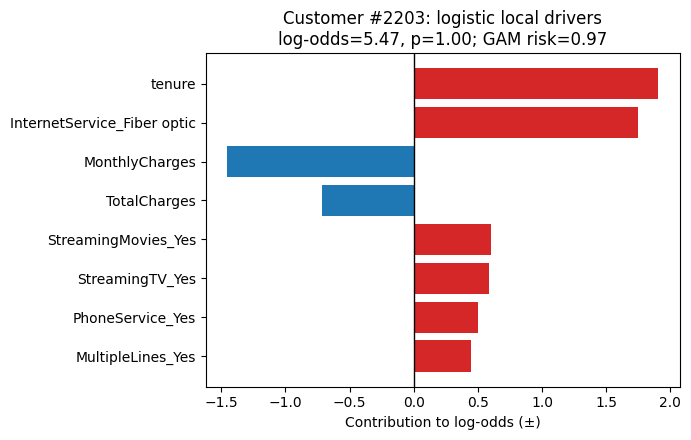

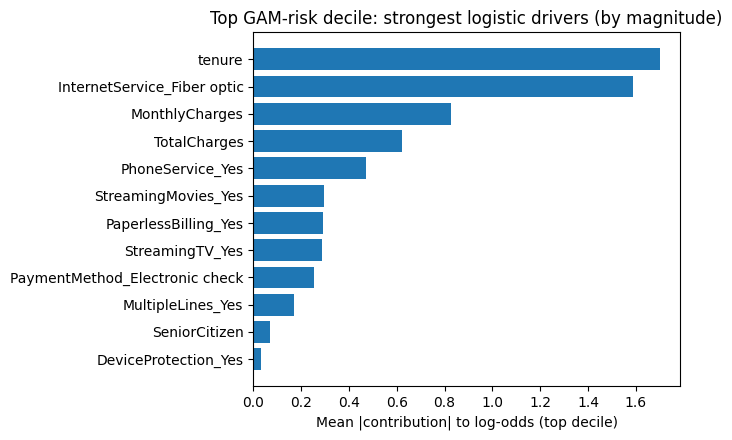

In [88]:
# Explain customer 2203, the customer with the highest GAM score
top_idx = int(np.argmax(gam_prob))
plot_customer_explanation(top_idx, top_k=8)

# Summarize drivers for the highest-risk decile (decile=9)
plot_decile_driver_summary(decile=9, top_m=12)


This hybrid output is designed for maximum interpretability. The GAM scores are used only to rank customers by churn risk (high recall, strong AUC), while the logistic model explains why each customer is high risk using simple, additive contributions to the log-odds.

How to interpret above example:

The example shows how ranking and explanation work together for one customer (row_id 2203). The GAM risk of 0.97 places this customer in the highest-risk decile, so the GAM is used to prioritize outreach. The logistic bar chart then explains why: each bar is that feature's local contribution to this customer's log-odds of churn (right of zero increases odds, left decreases), with continuous features mean-centered so effects are relative to an average customer and the bars summing to the total log-odds shown in the title (5.47 ≈ probability ~1.00). Here, short tenure and having fiber-optic internet provide the largest positive contributions, making the customer much more likely to churn, while monthly and total charges slightly offset risk. In the table, the top-3 drivers string encodes these largest contributions with a local odds multiplier (e.g., "x6.71" = exp(contribution)), and the `risk_decile` column confirms prioritization (9 = top 10%). In short, the GAM tells who is highest risk, and the logistic contributions state why and which factors to address in retention actions for this specific customer.


Why this is more interpretable:
- Ranking and recall come from the GAM, which captures nonlinearity and interactions.
- Explanations come from the logistic model's contributions-transparent and easy to justify to stakeholders.
- For a given customer, the bars sum to the total log-odds shown in the title, directly connecting what the model predicts to which features caused it.



#Citation & Push to Github

Some parts of this notebook, such as generating plot configurations, debugging, adding in comments for the code, etc, were done with OpenAI, model ChatGPT 5.